In [ ]:
# 🔧 Install Required Packages (Colab or fresh environment)

!pip install yt-dlp
!apt-get install -y ffmpeg  # in case it's not available
!pip install soundfile
!pip install git+https://github.com/openai/whisper.git


In [1]:
# Audio Download & Processing
import yt_dlp
import os
import soundfile as sf

# Whisper for Transcription
import whisper

# For Input and Time Calculation
import sys 


In [ ]:
# 1. Create a tools folder
!mkdir -p tools/ffmpeg

# 2. Download a static build (Linux 64-bit)
!wget -O tools/ffmpeg/ffmpeg-release.tar.xz https://johnvansickle.com/ffmpeg/releases/ffmpeg-release-amd64-static.tar.xz

# 3. Extract it
!tar -xf tools/ffmpeg/ffmpeg-release.tar.xz -C tools/ffmpeg --strip-components=1

# 4. Confirm it's there
!tools/ffmpeg/ffmpeg -version

## **Data Collection**
Audio Source: The audio data is collected using the **yt-dlp** package



*   With the yt_dl package we can download audio and video files from a URL and convert to a .wav file
*   Youtube_dl supports an extensive collection (~ 240) of websites




In [4]:
import yt_dlp
import os
import soundfile as sf

def download_audio_from_youtube(url, output_file='audio_yt.wav'):
    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': output_file,
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
        'ffmpeg_location': './tools/ffmpeg',  # 👈 Custom FFmpeg location
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    print(f"Downloaded and saved as {output_file}")

# 📥 Get user input and strip whitespace
url = input("Please enter a URL from which you want to download a video: ").strip()
download_audio_from_youtube(url)


Please enter a URL from which you want to download a video:  https://youtu.be/rmVRLeJRkl4?si=Zn1ZztZUEfuoi_I6


[youtube] Extracting URL: https://youtu.be/rmVRLeJRkl4?si=Zn1ZztZUEfuoi_I6
[youtube] rmVRLeJRkl4: Downloading webpage
[youtube] rmVRLeJRkl4: Downloading tv client config
[youtube] rmVRLeJRkl4: Downloading player 64be519f-main
[youtube] rmVRLeJRkl4: Downloading tv player API JSON
[youtube] rmVRLeJRkl4: Downloading ios player API JSON
[youtube] rmVRLeJRkl4: Downloading m3u8 information
[info] rmVRLeJRkl4: Downloading 1 format(s): 251
[download] Destination: audio_yt.wav
[download] 100% of   62.45MiB in 00:00:02 at 22.94MiB/s    
[ExtractAudio] Destination: audio_yt.wav.wav
Deleting original file audio_yt.wav (pass -k to keep)
Downloaded and saved as audio_yt.wav


# **Speech Recognition**

**Transcription Method**:  
To transcribe lecture audio into text, I used OpenAI’s **Whisper** — a state-of-the-art speech recognition model. 

Whisper is trained on **680,000+ hours** of multilingual and multitask supervised data collected from the web. This massive training scale gives it strong generalization capabilities, making it effective for:
- Handling **diverse accents and dialects**
- Performing well even with **low-quality or noisy audio**
- Supporting **multiple languages** (though this project focuses on English)

**Why Whisper?**
- It's **open-source and easy to integrate**
- Requires **minimal preprocessing** of audio files
- Unlike many traditional ASR tools, Whisper doesn’t need domain-specific fine-tuning to work well on lectures or spoken content

This choice ensures reliable transcription accuracy, which is critical for the quality of downstream NLP tasks like summarization, keyword extraction, or topic clustering.

**Model Choice**: The `base` model offers a good balance between speed and accuracy, making it suitable for moderate-length academic lectures with



In [ ]:
import torch
model = whisper.load_model("base").to("cuda" if torch.cuda.is_available() else "cpu")


###  Chunking Strategy for Transcription

The audio is transcribed in **60-second chunks** to balance **performance, accuracy, and context preservation**. Whisper performs more reliably on shorter segments, avoiding memory overload and ensuring stable output. 

A 60-second window is long enough to capture meaningful context (reducing the chance of broken or incomplete sentences) while keeping the system efficient. After transcription, all chunks are merged and cleaned to prepare a coherent text for downstream NLP tasks like summarization or topic clustering.


In [1]:
def transcribe_audio_in_chunks(file_path):
    # Read the audio file
    data, samplerate = sf.read(file_path)
    audio_length = int(len(data) / samplerate)

    # Set the chunk duration (in seconds)
    chunk_duration = 60
    number_of_chunks = int(audio_length / chunk_duration) + (audio_length % chunk_duration > 0)

    print(f"Total audio length: {audio_length} seconds")
    print(f"Number of chunks: {number_of_chunks}")

    complete_transcription = ""

    # Loop through the audio file in chunks
    for i in range(number_of_chunks):
        start = i * chunk_duration
        end = (i + 1) * chunk_duration
        if end > audio_length:
            end = audio_length

        # Extract the chunk
        start_frame = int(start * samplerate)
        end_frame = int(end * samplerate)
        chunk = data[start_frame:end_frame]

        # Save the chunk as a temporary file
        temp_filename = "temp_chunk.wav"
        sf.write(temp_filename, chunk, samplerate)

        # Transcribe the chunk using Whisper
        result = model.transcribe(temp_filename)
        complete_transcription += result["text"] + " "

        print(f"Transcribed chunk from {start} to {end} seconds.")

    return complete_transcription


In [ ]:
import os
os.environ["PATH"] = os.path.abspath("tools/ffmpeg") + os.pathsep + os.environ["PATH"]
transcription = transcribe_audio_in_chunks('audio_yt.wav.wav')
print("Complete Transcription: ", transcription)

In [2]:
file_path = "transcription.txt"  # change this to your actual file

with open(file_path, "r", encoding="utf-8") as f:
    transcription = f.read()

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

nltk.download('punkt_tab')

sentences = sent_tokenize(transcription)

chunk_size = 5
overlap = 1
chunks = []

i = 0
while i < len(sentences):
    chunk = sentences[i:i + chunk_size]
    chunks.append(' '.join(chunk))
    i += chunk_size - overlap  # move forward by (chunk_size - overlap)


In [4]:
word_counts = [len(chunk.split()) for chunk in chunks]
print(f"Total chunks: {len(chunks)}")
print(f"Average chunk length: {sum(word_counts)//len(word_counts)} words")
print(f"Range: {min(word_counts)}–{max(word_counts)} words")


Total chunks: 219
Average chunk length: 75 words
Range: 2–172 words


In [ ]:

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  


In [ ]:

chunk_embeddings = model.encode(chunks, normalize_embeddings=True)  


In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

similarity_matrix = cosine_similarity(chunk_embeddings)


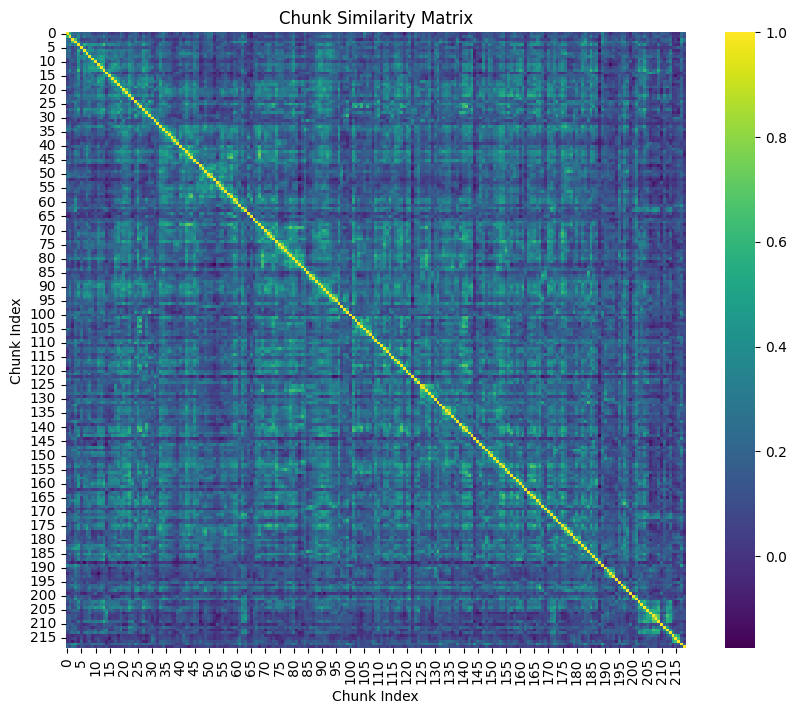

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis')
plt.title("Chunk Similarity Matrix")
plt.xlabel("Chunk Index")
plt.ylabel("Chunk Index")
plt.show()


In [ ]:
import networkx as nx
G = nx.Graph()
for i in range(len(chunks)):
    for j in range(i+1, len(chunks)):
        similarity = similarity_matrix[i][j]
        if similarity > 0.6: 
            G.add_edge(i, j, weight=similarity)


In [ ]:
!pip install python-louvain

import community as community_louvain

# Detect communities (topics)
partition = community_louvain.best_partition(G, resolution=1.0)



In [11]:
from collections import defaultdict

topics = defaultdict(list)
for idx, topic_id in partition.items():
    topics[topic_id].append(chunks[idx])


In [12]:
topics

defaultdict(list,
            {0: [" Hey guys, welcome to our last lecture of this quarter. And we're very happy to have a Dow here. He's a CEO of ContextualBI, Enterprise LLN company, as well as an adjunct professor in symbolic systems here at Stanford. And previously he was the head of research at Horton Bayes. And before that, a research scientist at Facebook, AI Research, he received this PhD in Masters from the University of Cambridge, as well as a Master's in Logic from the University of Amsterdam and studied philosophy and cognitive AI in undergrad.",
              "And before that, a research scientist at Facebook, AI Research, he received this PhD in Masters from the University of Cambridge, as well as a Master's in Logic from the University of Amsterdam and studied philosophy and cognitive AI in undergrad. Men whose work focuses on machine learning as well as NLP, specifically on developing better models for language understanding and generation, and better to go for evaluati

In [13]:
!pip install keybert
from keybert import KeyBERT
kw_model = KeyBERT()

topic_labels = {}

for topic_id, chunks in topics.items():
    combined_text = " ".join(chunks)
    keywords = kw_model.extract_keywords(combined_text, top_n=3)
    topic_title = ", ".join([kw[0] for kw in keywords])
    topic_labels[topic_id] = topic_title

# Print the topic titles
for tid, title in topic_labels.items():
    print(f"Topic {tid}: {title}")


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Topic 0: ai, phd, masters
Topic 1: retrieval, topics, multimodality
Topic 2: language, ai, models
Topic 3: language, generate, instruction
Topic 4: retrieval, wikipedia, rank
Topic 5: retrieval, decoder, optimize
Topic 6: encoder, encode, retrieval
Topic 8: systems, training, components
Topic 9: retrieval, idf, documents
Topic 10: tfi, retrieval, bm25
Topic 12: retrieval, sparse, sparses
Topic 13: search, vector, databases
Topic 21: databases, embeddings, sparse
Topic 15: algorithms, vectors, similarity
Topic 16: vectors, dot, similarity
Topic 17: retrieval, retriever, dragon
Topic 18: retrieval, hallucination, augmentation
Topic 20: retrieval, retriever, contextualization
Topic 24: bm25, vm25, replug
Topic 26: r

In [ ]:
from collections import Counter

all_keywords = []

for label in topic_labels.values():
    # Split each label into keywords (comma-separated)
    keywords = [kw.strip().lower() for kw in label.split(",")]
    all_keywords.extend(keywords)

# Count frequency
keyword_freq = Counter(all_keywords)

# Sort by frequency and alphabetically for tie-break
sorted_keywords = sorted(keyword_freq.items(), key=lambda x: (-x[1], x[0]))

# Pick top N unique root keywords
final_tags = []
used_roots = set()

for word, freq in sorted_keywords:
    root = word[:5]  # crude root check, adjust if needed
    if root not in used_roots and len(final_tags) < 7:
        final_tags.append(word)
        used_roots.add(root)

print("Final Tags for the Video:")
print(", ".join(final_tags))


📺 Final Tags for the Video:
retrieval, language, decoder, ai, bm25, databases, encode


In [17]:
!pip install transformers accelerate


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [39]:
from transformers import pipeline

# Load a strong language model
model_id = "HuggingFaceH4/zephyr-7b-alpha"  # or use "mistralai/Mistral-7B-Instruct-v0.1"
ta_writer = pipeline("text-generation", model=model_id, max_new_tokens=300, device=0)

def generate_ta_summary(text, label=None):
    prompt = f"""
You are a teaching assistant summarizing a lecture section for students.

Lecture Topic: "{label if label else 'General'}"

Transcript:
{text}

Please provide a clear and helpful summary for student notes.
"""
    result = ta_writer(prompt,return_full_text=False)[0]["generated_text"]
    return result.split("Transcript:")[-1].strip()


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Device set to use cuda:0


OutOfMemoryError: CUDA out of memory. Tried to allocate 500.00 MiB. GPU 0 has a total capacity of 47.53 GiB of which 206.88 MiB is free. Process 4192385 has 47.32 GiB memory in use. Of the allocated memory 46.84 GiB is allocated by PyTorch, and 176.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [31]:
ta_summaries = {}

for topic_id, chunk_list in topics.items():
    full_text = " ".join(chunk_list)
    label = topic_labels.get(topic_id, f"Topic {topic_id}")
    summary = generate_ta_summary(full_text, label)
    ta_summaries[label] = summary


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [32]:
for title, summary in ta_summaries.items():
    print(f"\n📌 {title}\n{summary}\n{'-'*100}")



📌 ai, phd, masters
Hey guys, welcome to our last lecture of this quarter. And we're very happy to have a Dow here. He's a CEO of ContextualBI, Enterprise LLN company, as well as an adjunct professor in symbolic systems here at Stanford. And previously he was the head of research at Horton Bayes. And before that, a research scientist at Facebook, AI Research, he received this PhD in Masters from the University of Cambridge, as well as a Master's in Logic from the University of Amsterdam and studied philosophy and cognitive AI in undergrad. And before that, a research scientist at Facebook, AI Research, he received this PhD in Masters from the University of Cambridge, as well as a Master's in Logic from the University of Amsterdam and studied philosophy and cognitive AI in undergrad. Men whose work focuses on machine learning as well as NLP, specifically on developing better models for language understanding and generation, and better to go for evaluation and benchmarking. Yeah, give it